# Simulate DWPC and p-value draws for a better null distribution

For a single degree combination within one metapath, adjusted DWPC values roughly follow a gamma hurdle distribution. Comparing draws from such a distribution to the null (sampling) distribution should give p-values that are uniformly distributed from 0 to `p_nz`-- the proportion nonzero-- with a spike at 1 to account for the zero DWPCs. 

Along a single metapath there are many degree combinations, each with different fractions `p_nz`. Each such distribution contributes to the metapath-level p-value distribution according to the frequency with which the degree combination occurs on the metapath. The one-inflated uniform distributions of p-values then "stack" when they are averaged in this way, leading to metapath-level p-value distributions that look like the function 1/p. 

Below, this method is applied to generate a superior null distribution for Hetionet p-values. For a single degree combination, the p-values of permutations compared to themselves are drawn from the one-inflated uniform distribution with parameter `p_nz`. This parameter is estimated for every degree combination using `nnz`/`n` from the degree-grouped permutations on the 200 permuted networks. In this way, the permuted networks are used to estimate the `p_nz` parameter for the p-value distribution of each degree combination. These distributions are then averaged (weighted by their frequency within the metapath) to give an estimate of the metapath p-value null distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas
import scipy.stats

import hetmech.hetmat

%matplotlib inline

In [2]:
hetmat = hetmech.hetmat.HetMat('../../data/hetionet-v1.0.hetmat/')

## Single degree-combination

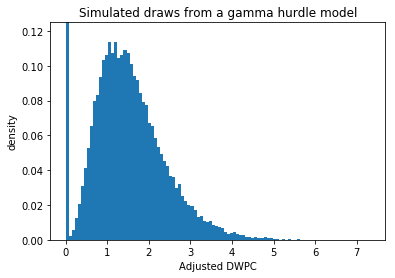

In [3]:
# Draw values from a gamma hurdle model
alpha, beta, p_nz = 4, 2.5, 0.2

num_draws = 100_000
num_nonzero = round(p_nz * num_draws)

draws = scipy.stats.gamma.rvs(alpha, loc=0, scale=1/beta, size=num_nonzero)
draws = numpy.concatenate((draws, numpy.zeros(num_draws - num_nonzero)))

heights, _, _ = plt.hist(draws, bins=100, density=True);
plt.title("Simulated draws from a gamma hurdle model")
plt.xlabel("Adjusted DWPC")
plt.ylabel('density')
plt.ylim((0, 1.1 * max(heights[1:])));

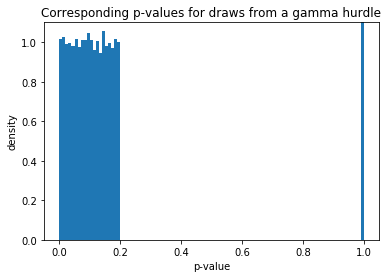

In [4]:
# Plot p-values of simulated gamma hurdle values, expect uniform distribution 
# up to nnz / n with large spike at one
p_values = list()
for draw in draws:
    if draw == 0:
        p = 1
    else:
        p = p_nz * (1 - scipy.stats.gamma.cdf(draw, alpha, 0, 1/beta))
    p_values.append(p)

plt.hist(p_values, bins=100, density=True);
plt.title("Corresponding p-values for draws from a gamma hurdle")
plt.xlabel('p-value')
plt.ylabel('density')
plt.ylim((0, 1.1));

## Example simulated p-values
The p-values of a complete metapath are the combination of p-values from many such partially uniform distributions. When the distribution of all p-values for a single metapath are shown, they are no longer uniformly distributed.

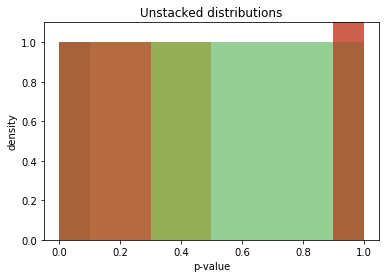

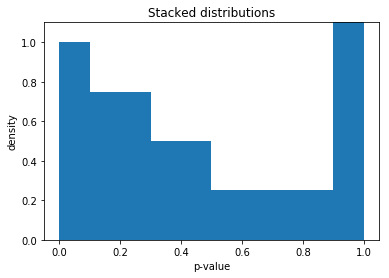

In [5]:
# Without stacking
for frac_nz in {0.0999, 0.2999, 0.4999, 0.8999}:
    values_nz = numpy.linspace(0, frac_nz, round(20*frac_nz))
    values = numpy.concatenate((values_nz, numpy.ones(20 - len(values_nz))))
    plt.hist(values, range=(0, 1), density=True, alpha=0.5, bins=10)
    plt.title("Unstacked distributions")
    plt.xlabel('p-value')
    plt.ylabel('density')
    plt.ylim((0, 1.1));

# With stacking
num_per = 100
total_values = numpy.array([])
for frac_nz in {0.0999, 0.2999, 0.4999, 0.8999}:
    values_nz = numpy.linspace(0, frac_nz, round(num_per*frac_nz))
    total_values = numpy.concatenate((total_values, values_nz, numpy.ones(num_per - len(values_nz))))

plt.figure()
plt.hist(total_values, range=(0, 1), density=True)
plt.title("Stacked distributions")
plt.xlabel('p-value')
plt.ylabel('density')
plt.ylim((0, 1.1));

## Single metapath, all degree combinations

As the number of degree-grouped permutations values increases, the distribution of p-values along a degree combination will tend increasingly toward a one-inflated uniform distribution, as shown above. Using this knowledge, we can use the 200 existing permutations to get reasonable estimates of the two parameters, `n` and `nnz`. These estimates allow us to generate a null distribution for the DWPC value along any degree combination. We can average the degree combination PDFs according to how frequently they appear in the metapath.

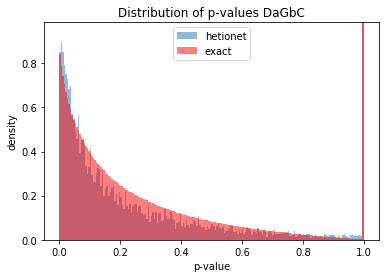

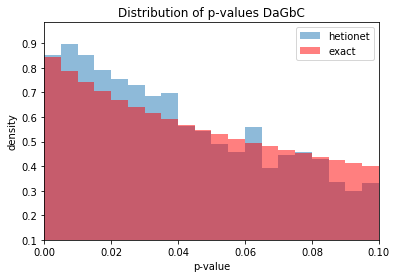

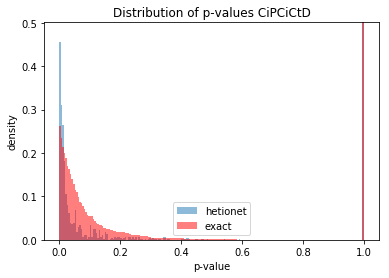

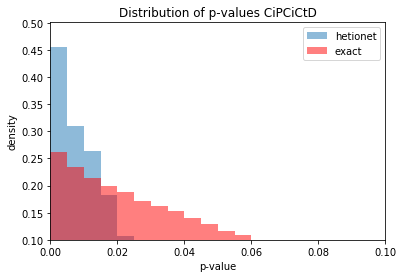

In [6]:
num_bins = 200
bin_width = 1 / num_bins

for metapath in ['DaGbC', 'CiPCiCtD']:
    # Load previously computed data, including n, nnz, and hetionet p-value (using gamma hurdle)
    path = hetmat.directory.joinpath('adjusted-path-counts', 'dwpc-0.5', 'adjusted-dwpcs', f'{metapath}.tsv.gz')
    df = pandas.read_table(path, compression='gzip')
    n_nnz = df[['n', 'nnz']].values

    # Sum the PDFs of degree combinations
    overall_pdf = numpy.zeros(num_bins)
    for n, nnz in n_nnz:
        if nnz:
            hist, bins = numpy.histogram(numpy.linspace(0, nnz/n, nnz), bins=num_bins, range=(0,1))
        else:
            hist = numpy.zeros(num_bins)
        hist[-1] += (n - nnz)
        hist = hist / (bin_width * n)
        overall_pdf += hist
    
    # Divide by the number of values to get the averaged PDF
    overall_pdf = overall_pdf / len(n_nnz)
    
    # Plot the distributions
    plt.figure()
    heights, _, _ = plt.hist(df['p_value'], bins=num_bins, density=True, label='hetionet', alpha=0.5)
    plt.bar(bins[:-1], overall_pdf, width=bin_width, align='edge', alpha=0.5, label='exact', color='r')
    plt.legend()
    plt.title(f"Distribution of p-values {metapath}")
    plt.xlabel('p-value')
    plt.ylabel('density')
    plt.ylim((0, 1.1 * max(heights[:-1])));
    
    # Plot the distributions (zoomed on the upper left)
    plt.figure()
    heights, _, _ = plt.hist(df['p_value'], bins=num_bins, density=True, label='hetionet', alpha=0.5)
    plt.bar(bins[:-1], overall_pdf, width=bin_width, align='edge', alpha=0.5, label='exact', color='r')
    plt.legend()
    plt.title(f"Distribution of p-values {metapath}")
    plt.xlabel('p-value')
    plt.ylabel('density')
    plt.xlim((0, 0.1))
    plt.ylim((0.1, 1.1 * max(heights[:-1])));